# Final Model

## Setup dello Script e Caricamento dei Modelli

- Caricamento del modello di object recognition.
- Caricamento del face detection con Haar Cascades.
- Caricamento dei modelli per text recognition e number recognition.
- Caricamento del chatbot per le domande sull’immagine.

In [127]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import LSTM
import tensorflow as tf
import torch.nn.functional as F
import json
from tensorflow.keras.preprocessing.text import Tokenizer
import torch
import torch.nn as nn
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disabilita la GPU

In [96]:
# Percorsi dei modelli
CHATBOT_MODEL_PATH = "/home/pierluigi/Documents/models/Chatbot/vqa_model.h5"
FACE_CASCADE_PATH = "/home/pierluigi/Documents/models/Face Detenction/haarcascades/haarcascade_frontalface_default.xml"
NUMBER_RECOGNITION_MODEL_PATH = "/home/pierluigi/Documents/models/Number Recognition/number_recognition_model.h5"
TEXT_RECOGNITION_MODEL_PATH = "/home/pierluigi/Documents/models/Text Recognition/text_recognition_model.h5"
OBJECT_RECOGNITION_MODEL_PATH = "/home/pierluigi/Documents/models/Object Recognition/object_recognition_model.pth"

In [97]:
# Caricamento del face detector
face_cascade = cv2.CascadeClassifier(FACE_CASCADE_PATH)
print("Modello Face Detection caricato correttamente.")

Modello Face Detection caricato correttamente.


In [98]:
# Caricamento del modello di riconoscimento dei numeri con custom_objects
number_recognition_model = load_model(
    NUMBER_RECOGNITION_MODEL_PATH,
    custom_objects={'softmax_v2': softmax}
)

print("Modello Number Recognition caricato correttamente.")

Modello Number Recognition caricato correttamente.


In [99]:
# Caricamento del modello Chatbot
chatbot_model = load_model(CHATBOT_MODEL_PATH)
print("Modello Chatbot caricato correttamente.")

Modello Chatbot caricato correttamente.


In [100]:
class ObjectRecognitionModel(nn.Module):
    def __init__(self):
        super(ObjectRecognitionModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Adattamento delle dimensioni a 256 * 14 * 14
        self.fc1 = nn.Linear(256 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 10)  # Modifica il numero di classi in base al dataset

    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)  # Appiattisce l'output per passarlo al livello FC
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [101]:
# Istanzia il modello
object_recognition_model = ObjectRecognitionModel()
print("Modello Object Recognition caricato correttamente.")

Modello Object Recognition caricato correttamente.


## Predicting the Content of Images

In [102]:
# Funzione per preparare l'immagine per ogni modello
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (224, 224))  # Dimensioni generiche per i modelli CNN
    img_array = np.expand_dims(img_resized, axis=0)
    return img, img_array / 255.0  # Normalizza l'immagine

In [103]:
# Funzione per eseguire il modello di riconoscimento dei numeri
def predict_number(img):
    # Converti l'immagine in scala di grigi e ridimensiona a 28x28 per il modello
    gray_img = cv2.cvtColor((img[0] * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    gray_img_resized = cv2.resize(gray_img, (28, 28))  # Ridimensiona a 28x28
    gray_img_reshaped = gray_img_resized.reshape(28, 28, 1)  # Forma (28, 28, 1) per TensorFlow/Keras

    # Espande la dimensione batch per ottenere la forma (1, 28, 28, 1)
    gray_img_tensor = np.expand_dims(gray_img_reshaped, axis=0)

    # Effettua la previsione
    prediction = number_recognition_model.predict(gray_img_tensor)
    max_prob = np.max(prediction)
    predicted_class = np.argmax(prediction)
    return predicted_class, max_prob


In [118]:
# Funzione per eseguire il modello di riconoscimento degli oggetti
def predict_object(img):
    # Ridimensiona l'immagine alla dimensione prevista dal modello, ad esempio 224x224
    img_resized = cv2.resize(img[0], (224, 224))  # Ridimensiona l'immagine per il modello
    img_tensor = torch.tensor(img_resized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0  # Forma (1, 3, 224, 224)

    with torch.no_grad():
        prediction = object_recognition_model(img_tensor)
    probabilities = torch.softmax(prediction, dim=1).cpu().numpy()
    max_prob = np.max(probabilities)
    predicted_class = np.argmax(probabilities)
    return predicted_class, max_prob


In [105]:
# Funzione per eseguire il face detection
def predict_faces(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    return len(faces), len(faces) > 0  # Ritorna il numero di volti e una probabilità (bool)

In [113]:
def analyze_image(image_path):
    # Caricamento e visualizzazione dell'immagine
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Converti in RGB per matplotlib
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("Immagine di input")
    plt.show()

    # Preprocessamento dell'immagine per i modelli
    processed_img = preprocess_image(image_path)
    results = {}

    # Esegui Number Recognition
    number_class, number_prob = predict_number(processed_img)
    results['Number Recognition'] = (number_class, number_prob)

    # Esegui Object Recognition
    object_class, object_prob = predict_object(processed_img)
    results['Object Recognition'] = (object_class, object_prob)

    # Esegui Face Detection
    face_count, face_prob = predict_faces(img)  # Usa l'immagine originale per la face detection
    results['Face Detection'] = (face_count, face_prob)

    # Visualizza i risultati
    print("Risultati del riconoscimento dell'immagine:")
    for key, (pred, prob) in results.items():
        print(f"{key}: Predizione - {pred}, Probabilità - {prob:.2f}")

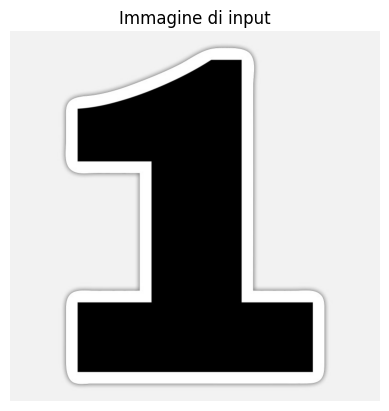

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Risultati del riconoscimento dell'immagine:
Number Recognition: Predizione - 1, Probabilità - 1.00
Object Recognition: Predizione - 8, Probabilità - 0.10
Face Detection: Predizione - 0, Probabilità - 0.00


In [119]:
analyze_image("/home/pierluigi/Documents/datasets/Object Detenction 2/1.jpg")

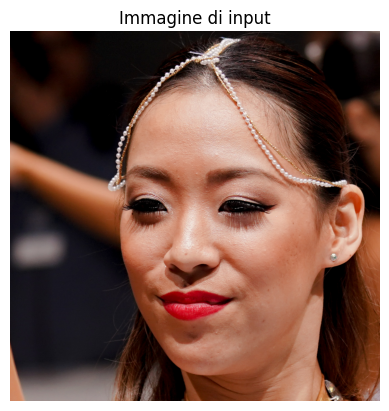

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Risultati del riconoscimento dell'immagine:
Number Recognition: Predizione - 8, Probabilità - 1.00
Object Recognition: Predizione - 8, Probabilità - 0.10
Face Detection: Predizione - 1, Probabilità - 1.00


In [124]:
analyze_image("/home/pierluigi/Documents/datasets/Face Detenction/01000/01001.png")

## Asking Chatbot

In [128]:
# Carica le domande dal dataset usato in fase di addestramento
with open("/home/pierluigi/Documents/datasets/Chatbot/VQA Input Questions/v2_OpenEnded_mscoco_train2014_questions.json") as f:
    data = json.load(f)
    questions = [q['question'] for q in data['questions']]

# Inizializza e addestra il tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(questions)

In [129]:
def preprocess_question(question, tokenizer, max_length=20):
    sequence = tokenizer.texts_to_sequences([question])
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_length, padding='post')
    return padded_sequence

def ask_chatbot(question):
    # Preprocessa la domanda
    question_seq = preprocess_question(question, tokenizer)

    # Genera la risposta con il modello del chatbot
    answer_pred = chatbot_model.predict([np.zeros((1, 224, 224, 3)), question_seq])  # Passiamo un'immagine vuota per questo esempio
    answer_index = np.argmax(answer_pred)
    answer_text = tokenizer.index_word.get(answer_index, "Unknown")
    
    return answer_text

In [132]:
def analyze_image_final(image_path):
    # Caricamento e visualizzazione dell'immagine
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("Immagine di input")
    plt.show()

    # Preprocessamento dell'immagine per i modelli
    processed_img = preprocess_image(image_path)
    results = {}

    # Esegui Number Recognition
    number_class, number_prob = predict_number(processed_img)
    results['Number Recognition'] = (number_class, number_prob)

    # Esegui Object Recognition
    object_class, object_prob = predict_object(processed_img)
    results['Object Recognition'] = (object_class, object_prob)

    # Esegui Face Detection
    face_count, face_prob = predict_faces(img)
    results['Face Detection'] = (face_count, face_prob)

    # Visualizza i risultati
    print("Risultati del riconoscimento dell'immagine:")
    for key, (pred, prob) in results.items():
        print(f"{key}: Predizione - {pred}, Probabilità - {prob:.2f}")

    # Chiedi al chatbot una domanda
    question = input("Ask the chatbot.")
    chatbot_response = ask_chatbot(question)
    print(f"Risposta del chatbot: {chatbot_response}")

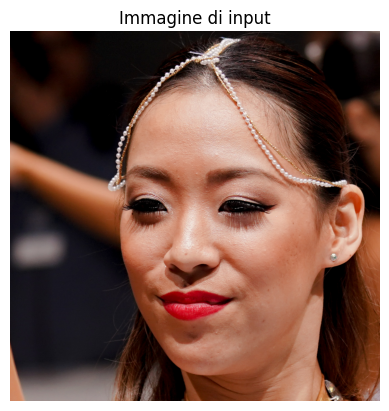

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Risultati del riconoscimento dell'immagine:
Number Recognition: Predizione - 8, Probabilità - 1.00
Object Recognition: Predizione - 8, Probabilità - 0.10
Face Detection: Predizione - 1, Probabilità - 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Risposta del chatbot: of


In [136]:
# Esegui la funzione con il percorso dell'immagine desiderata
analyze_image_final("/home/pierluigi/Documents/datasets/Face Detenction/01000/01001.png")